In [90]:
import cv2
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset, SubsetRandomSampler
import matplotlib.pyplot as plt
import torchvision
import glob
import random


In [91]:
class LungCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images (train/test/valid).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.transform = transform
        self.labels = {"adenocarcinoma": 0, "large.cell.carcinoma": 1, "normal": 2, "squamous.cell.carcinoma": 3}
        self.data = []
        self.targets = []

        # Load each subfolder name as a category
        for label, idx in self.labels.items():
            for f in glob.iglob(f"{root_dir}/{label}/*.jpg"):
                img = cv2.imread(f)
                img = cv2.resize(img, (224, 224))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = np.transpose(img, (2, 0, 1))  # Channel first

                if self.transform:
                    img = self.transform(img)

                self.data.append(img)
                self.targets.append(idx)

        # Convert to numpy arrays
        self.data = np.array(self.data, dtype=np.float32)
        self.targets = np.array(self.targets, dtype=np.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = {'image': self.data[index], 'label': self.targets[index]}
        return sample

    def normalize(self):
        self.data = self.data / 255.0

# Example of usage:
dataset = LungCancerDataset(root_dir='./data/train')
dataloader = DataLoader(dataset, shuffle=True)

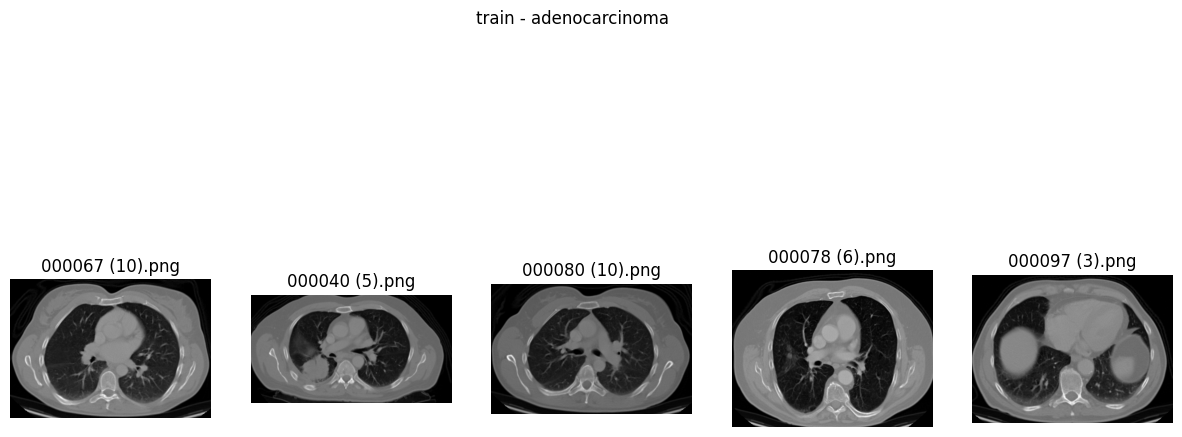

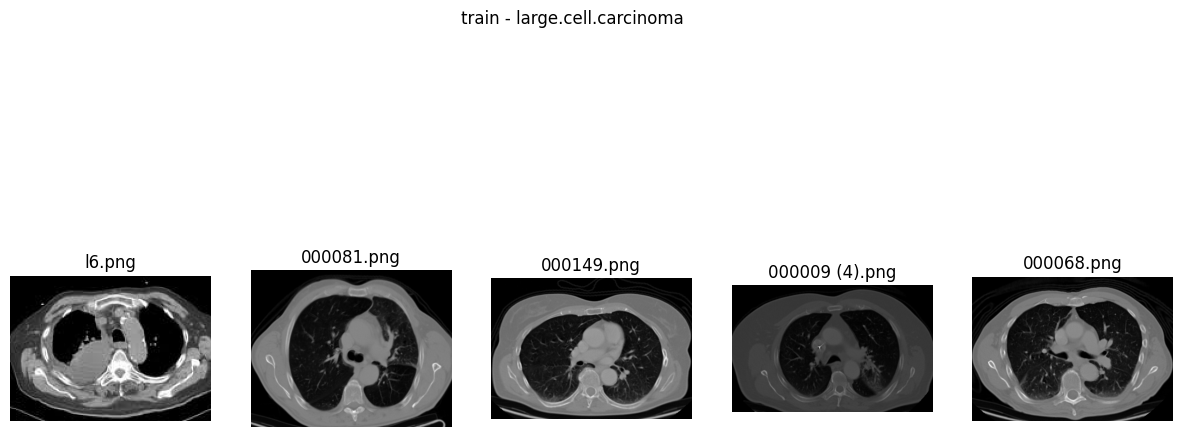

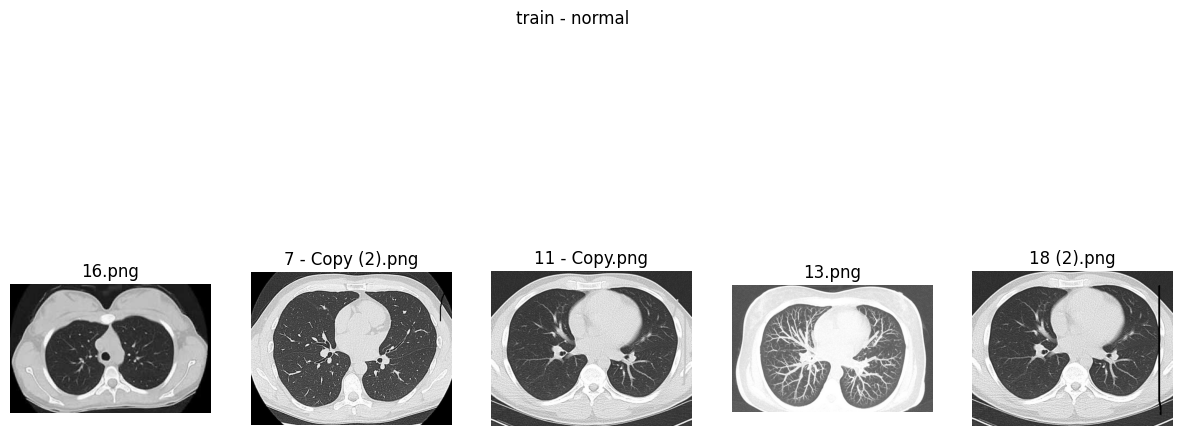

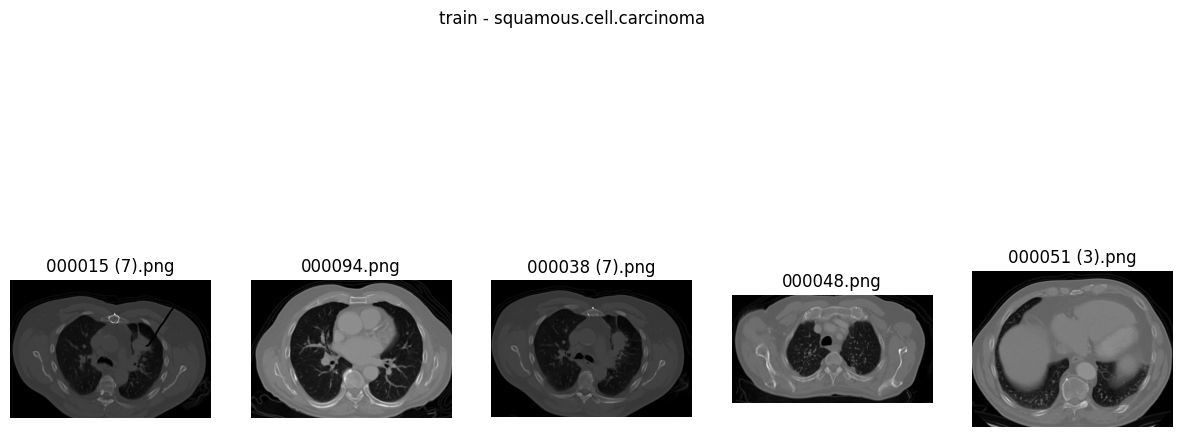

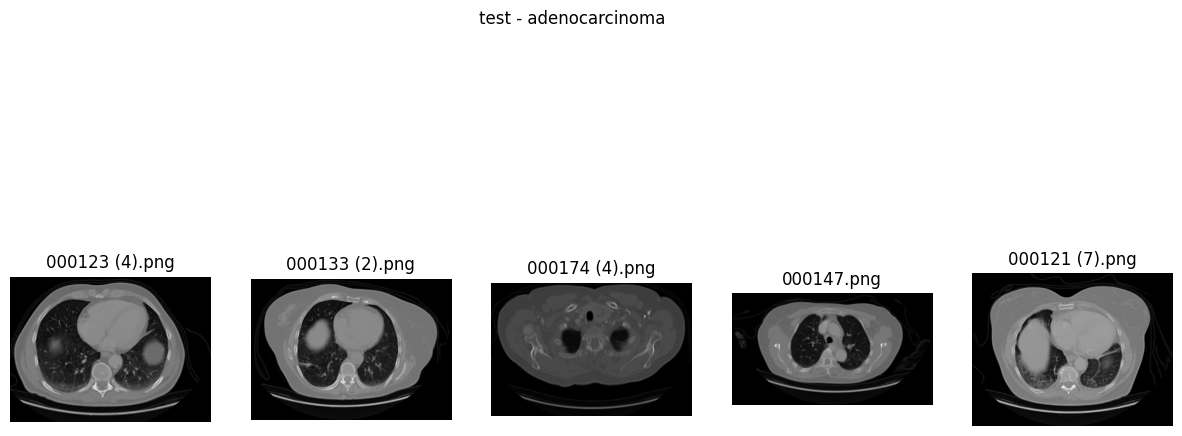

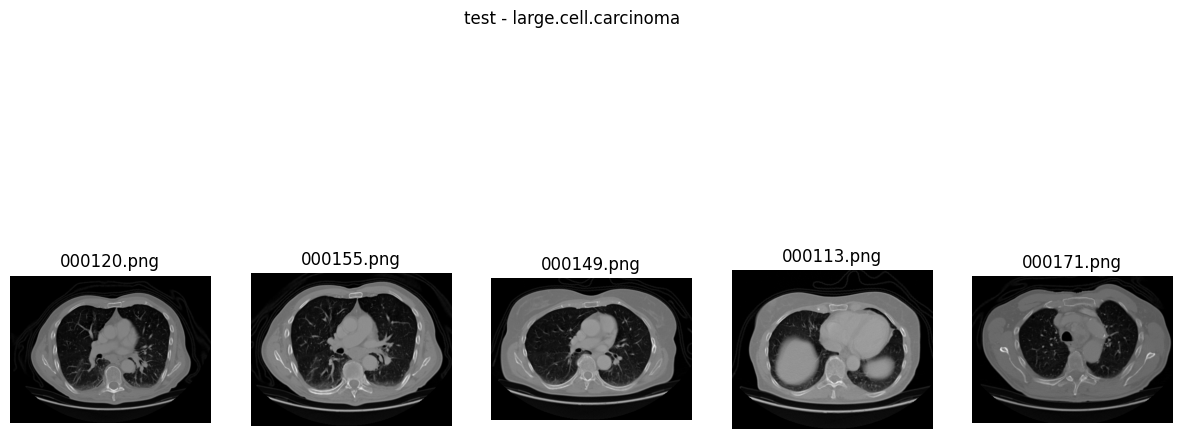

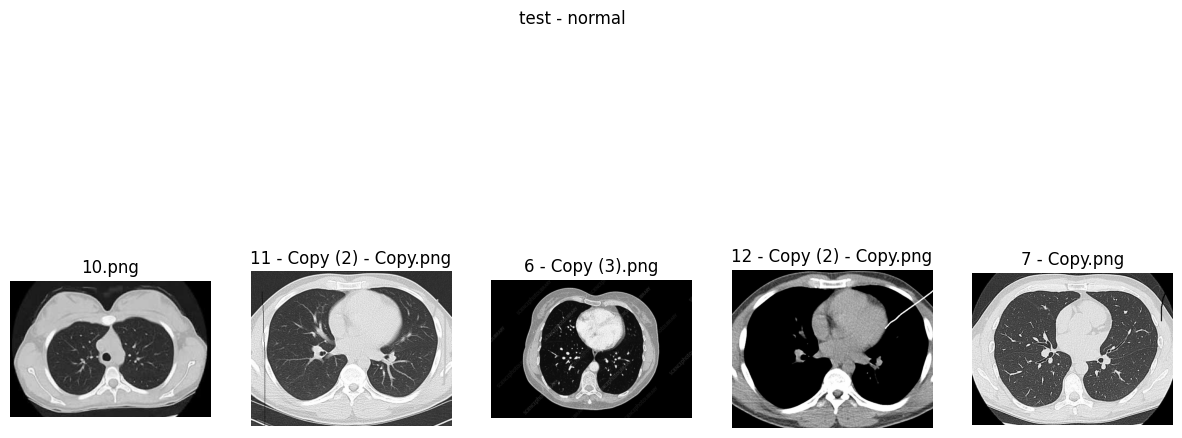

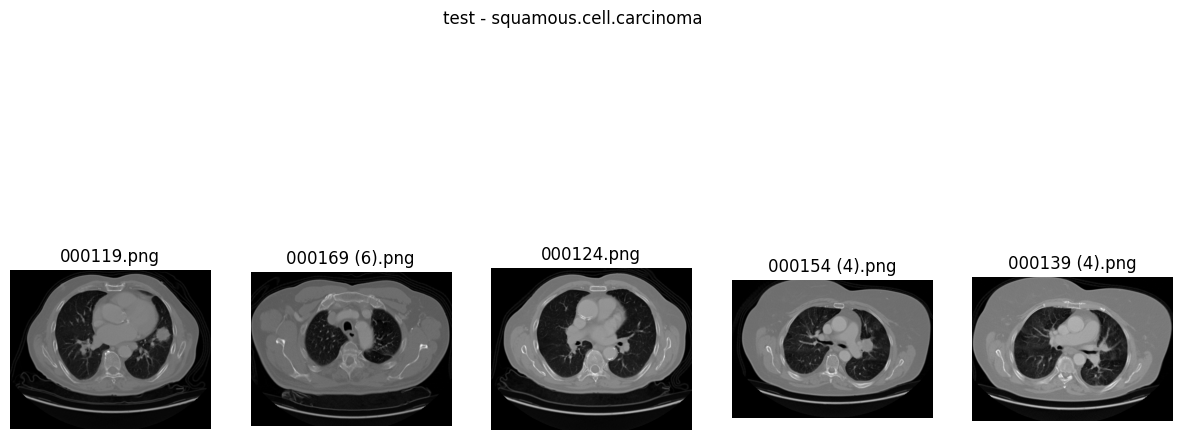

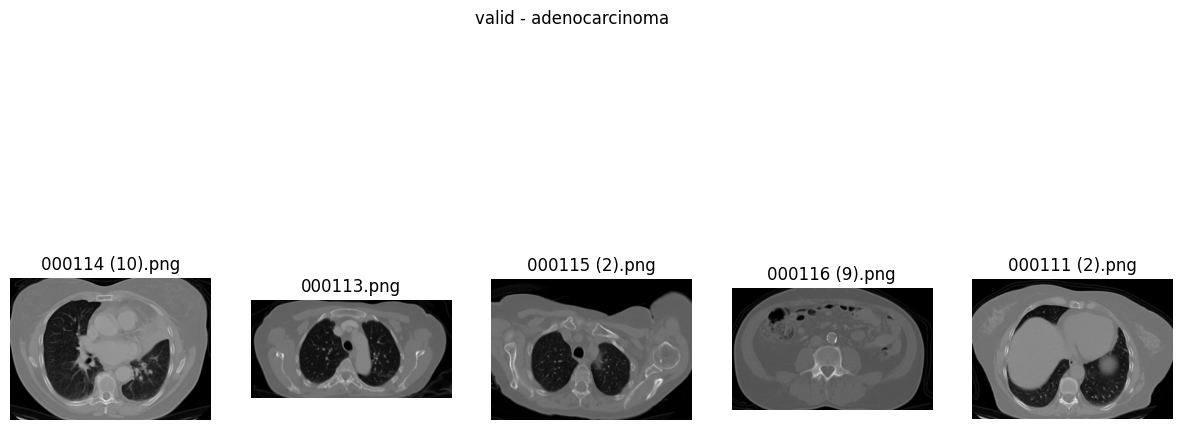

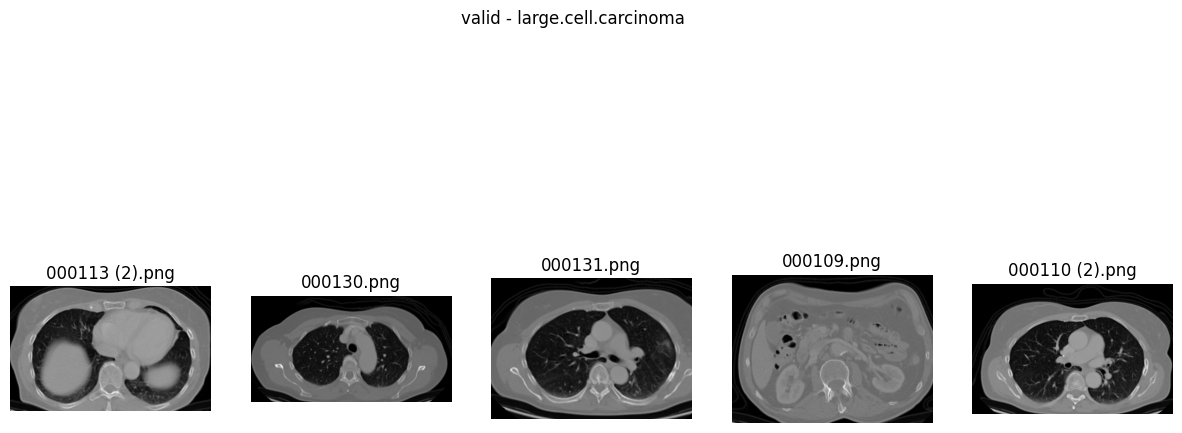

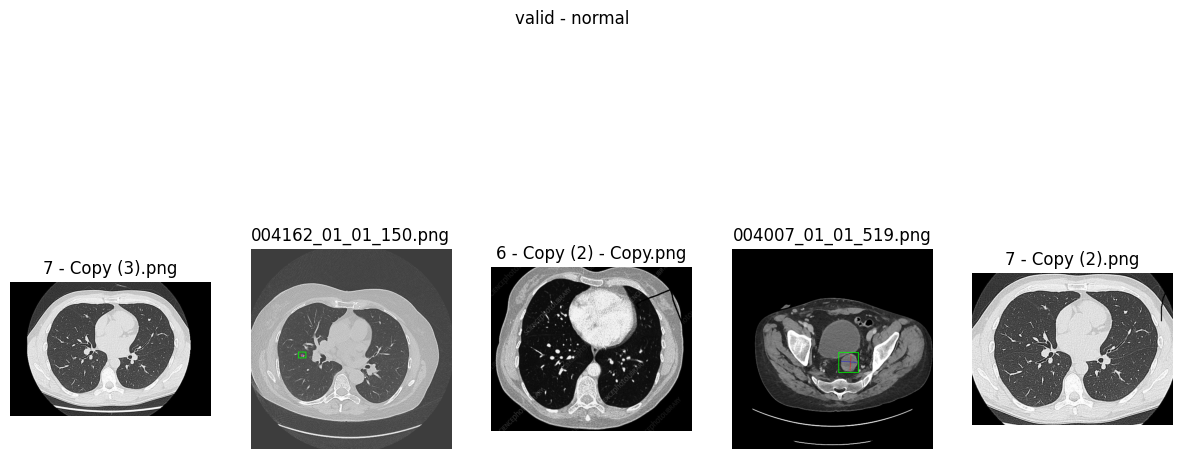

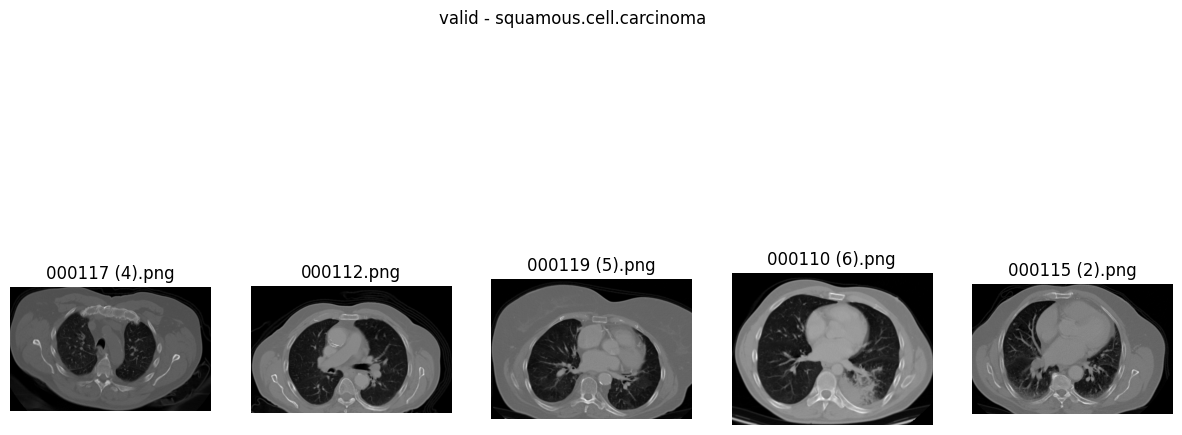

In [92]:
def plot_images_from_subdatasets(base_path, subdatasets, categories, num_images=5):
    """
    Plots a specified number of images for each category from each subdataset.

    Args:
        base_path (str): The base directory containing the subdatasets.
        subdatasets (list): List of subdataset names, such as ['train', 'test', 'valid'].
        categories (list): List of categories to display.
        num_images (int): Number of images to display from each category and subdataset.
    """
    for subdataset in subdatasets:
        for category in categories:
            # Path to the category directory
            category_dir = os.path.join(base_path, subdataset, category)
            images = os.listdir(category_dir)
            selected_images = random.sample(images, min(num_images, len(images)))

            # Create a figure for the selected images
            plt.figure(figsize=(15, 7))
            plt.subplots_adjust(left=0.05, right=0.95, wspace=0.1, hspace=0.2)
            plt.suptitle(f'{subdataset} - {category}')
            
            for i, image_name in enumerate(selected_images):
                img_path = os.path.join(category_dir, image_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                
                plt.subplot(1, num_images, i + 1)
                plt.imshow(img)
                plt.title(image_name)
                plt.axis('off')

            plt.show()

# Usage
base_path = 'data'
subdatasets = ['train', 'test', 'valid']
categories = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
plot_images_from_subdatasets(base_path, subdatasets, categories)



## CNN Architecture explanation

The architecture of a Convolutional Neural Network (CNN) typically involves a series of convolutional layers, pooling layers, and fully connected layers. The specific numbers of each type of layer and their configurations can be chosen based on empirical evidence, computational resources, and the complexity of the task at hand. Here's the rationale for the architecture I provided:

    Convolutional Layers:
        These layers are the core building blocks of a CNN. They apply a number of filters (also known as kernels) to the input to create feature maps. These feature maps capture spatial hierarchies and features (e.g., edges, textures) from the input images. Increasing the number of convolutional layers allows the network to learn more complex patterns. As we go deeper into the network, the filters can capture higher-level features (e.g., shapes, specific parts of an object).

    Number of Filters:
        The number of filters in each convolutional layer often increases with the depth of the network. This is because the complexity and the number of high-level features tend to increase as you move deeper, and more filters are needed to capture this complexity. Common practice is to double the number of filters after each pooling layer, which helps to balance the reduction in spatial dimensions.

    Pooling Layers:
        Pooling layers (in this case, max pooling) are used to reduce the spatial size of the representation, which decreases the number of parameters and computation in the network. This also helps to make the detection of features somewhat invariant to scale and orientation changes. Pooling helps to control overfitting by providing an abstracted form of the representation.

    Fully Connected Layers(commonly refered as fully connected(fc) layers):
        After the convolutional and pooling layers, the high-level reasoning in the neural network is done via fully connected layers. Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. The last fully connected layer (which is often called the "output layer") has as many neurons as there are classes in the dataset for a classification task. Each neuron in this layer will correspond to a class score.

    Activation Functions:
        The ReLU activation function is used after each convolution operation to introduce non-linear properties to the system, allowing the network to learn more complex functions.

The architecture I described is a simple and somewhat generic model for illustrative purposes. In practice, the architecture might need adjustments. For instance, if the images are larger, you may have additional layers to further reduce the spatial dimensions before flattening for the fully connected layers. If there are more or fewer classes, or if the images are more or less complex, you would adjust the depth of the network and the number of neurons in the fully connected layers accordingly.

Additionally, state-of-the-art CNN architectures like ResNet, Inception, and DenseNet use a lot of other strategies like skip connections, depth-wise separable convolutions, and densely connected layers to improve performance. These designs are often the result of extensive experimentation and research to optimize network performance on large-scale image recognition tasks.

In [93]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 4): # num_classes should match the number of your dataset's classes
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

### Pooling layer inputs 

    nn.MaxPool2d: Indicates that this is a 2-dimensional max pooling layer. Max pooling takes the maximum value over each patch of the feature map within the specified kernel size.

    kernel_size=2: Defines the size of the window over which the max operation is performed. In this case, it's a 2x2 window.

    stride=2: Determines the step size of the window as it slides over the feature map. A stride of 2 means that the window will move 2 pixels at a time, which reduces the size of the feature map by half.

### Why 2 linear layers 

    self.fc1: This is the first fully connected layer. It takes the flattened output from the last pooling layer as input. In the given example, the input size is 128 * 28 * 28, which is the number of features from the last convolutional layer (128 feature maps) times the size of each feature map after pooling (28 x 28). The 512 is an arbitrary number of neurons in this layer and is a hyperparameter that you can tune. This layer's purpose is to take the numerous features and begin the process of combining them in various ways to identify more complex patterns that can be used for classification.

    self.fc2: This is the second and final fully connected layer in the model, which acts as the output layer. It takes as input the number of neurons in the previous fully connected layer (512 in this case) and outputs a vector of size num_classes, where num_classes represents the number of target classes for your classification task. The output of this layer is then typically passed through a softmax function (not shown in the forward method because it's often included in the loss function in PyTorch, nn.CrossEntropyLoss), which converts the logits to probabilities for each class.

    The exact size of the input to the first fully connected layer depends on the size of the output from the final pooling layer, so you would need to calculate this based on your network's specific architecture. If you change the size of the images or the architecture of the convolutional and pooling layers, you'll need to adjust the input dimension of self.fc1 accordingly.

### Why ReLU (Rectified Linear Unit)  instead of tanh (hyperbolic tangent)
ReLU is generally preferred due to its computational efficiency and because it helps alleviate the vanishing gradient problem, leading to faster convergence in many cases. However, the best choice can depend on the specific problem and the architecture of the network. It's common to try different activation functions and empirically determine which one works best for your specific task.